In [1]:
import sys

sys.path.append('../xor_neuron')

import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

import plotly.graph_objects as go

In [2]:
def make_contour_plane(data, num, nb):
    xy_plane = []
    yz_plane = []
    zx_plane = []

    for raw in data:
        if raw[0] == -num:
            yz_plane.append(raw[-1])

        if raw[1] == num:
            zx_plane.append(raw[-1])

        if raw[2] == -num:
            xy_plane.append(raw[-1])

    xy_plane = np.array(xy_plane)
    yz_plane = np.array(yz_plane)
    zx_plane = np.array(zx_plane)

    xy_plane = xy_plane.reshape(nb,nb)
    yz_plane = yz_plane.reshape(nb,nb).T
    zx_plane = zx_plane.reshape(nb,nb).T

    return xy_plane, yz_plane, zx_plane

In [3]:
num = 4
nb = 81

x = np.linspace(-num, num, nb)
y = np.linspace(-num, num, nb)
z = np.linspace(-num, num, nb)

xv, yv, zv = np.meshgrid(x, y, z)

xyz = np.vstack([xv.reshape(-1), yv.reshape(-1), zv.reshape(-1)]).T

xx, yy = np.meshgrid(x, y)

In [6]:
dirs = glob("../exp/MLP_3D_arg/MNIST/*")
dirs.sort(key=os.path.abspath)
dirs

['../exp/MLP_3D_arg/MNIST/ComplexNeuronMLP_1_mnist_0858',
 '../exp/MLP_3D_arg/MNIST/ComplexNeuronMLP_2_mnist_0858',
 '../exp/MLP_3D_arg/MNIST/ComplexNeuronMLP_3_mnist_0635',
 '../exp/MLP_3D_arg/MNIST/ComplexNeuronMLP_4_mnist_0635']

In [7]:
dirs2 = glob("../exp/3D_ARG/MLP_MNIST/*")
dirs2.sort(key=os.path.abspath)
dirs2

['../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_10_mnist_0800',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_11_mnist_1752',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_12_mnist_0336',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_13_mnist_0800',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_14_mnist_1744',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_15_mnist_0315',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_16_mnist_0800',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_17_mnist_1741',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_18_mnist_0315',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_19_mnist_0800',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_20_mnist_1744',
 '../exp/3D_ARG/MLP_MNIST/ComplexNeuronMLP_21_mnist_0323']

In [9]:
dirs = dirs + dirs2
len(dirs)

16

In [11]:
for ii, dr in enumerate(dirs):
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    print(config.seed)

35
65
406
365
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122


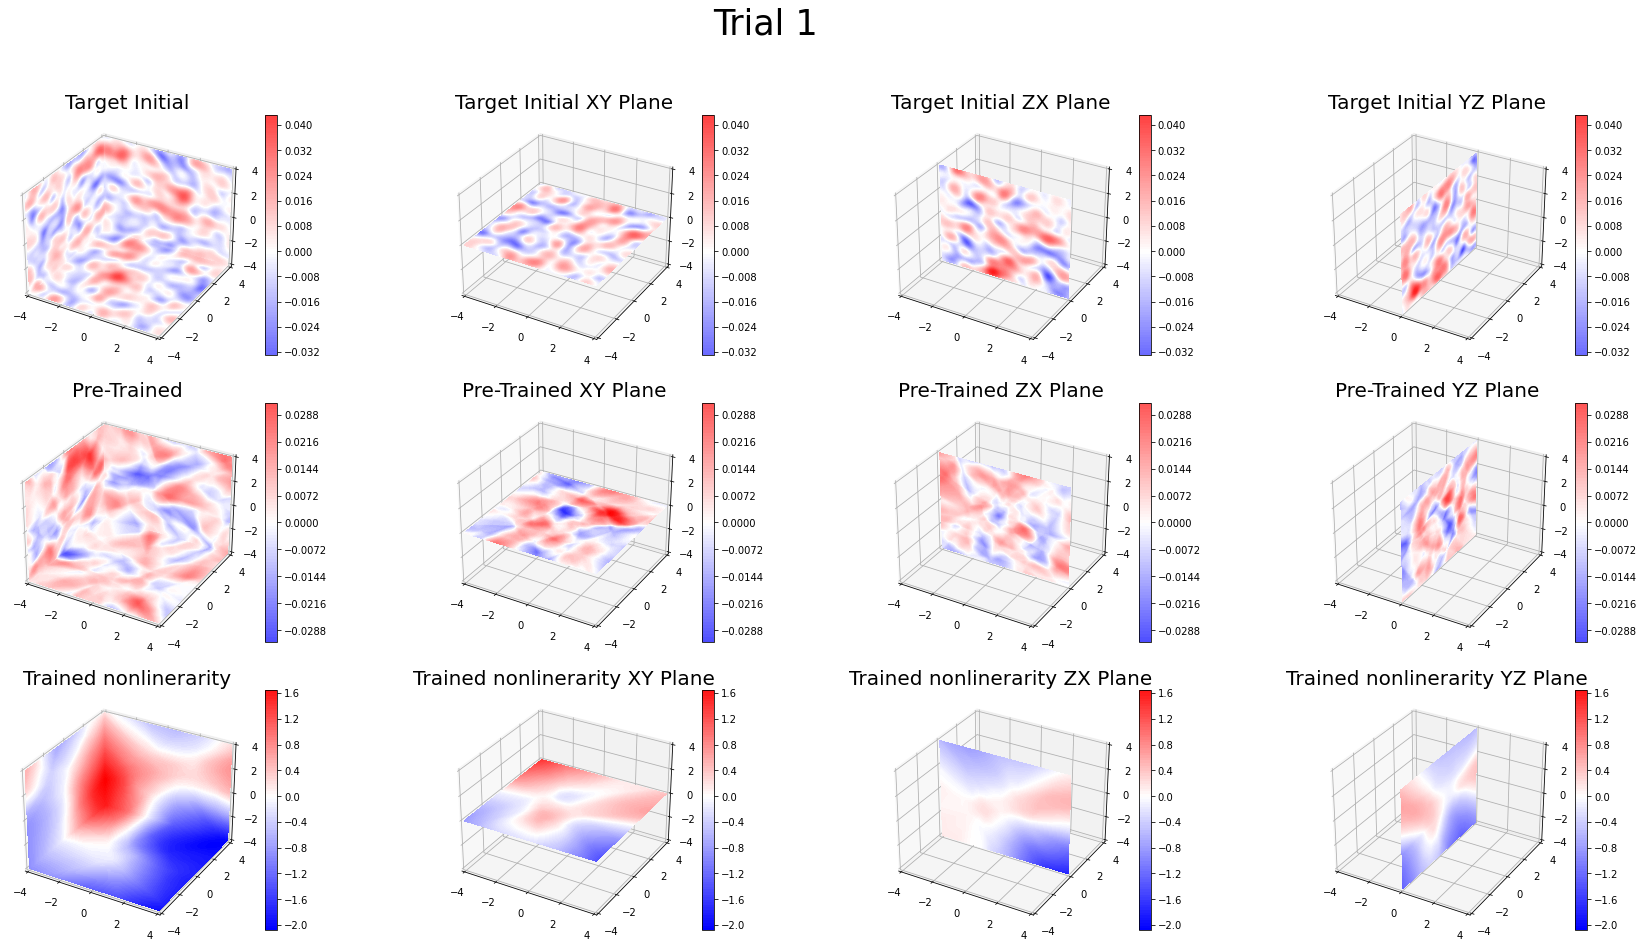

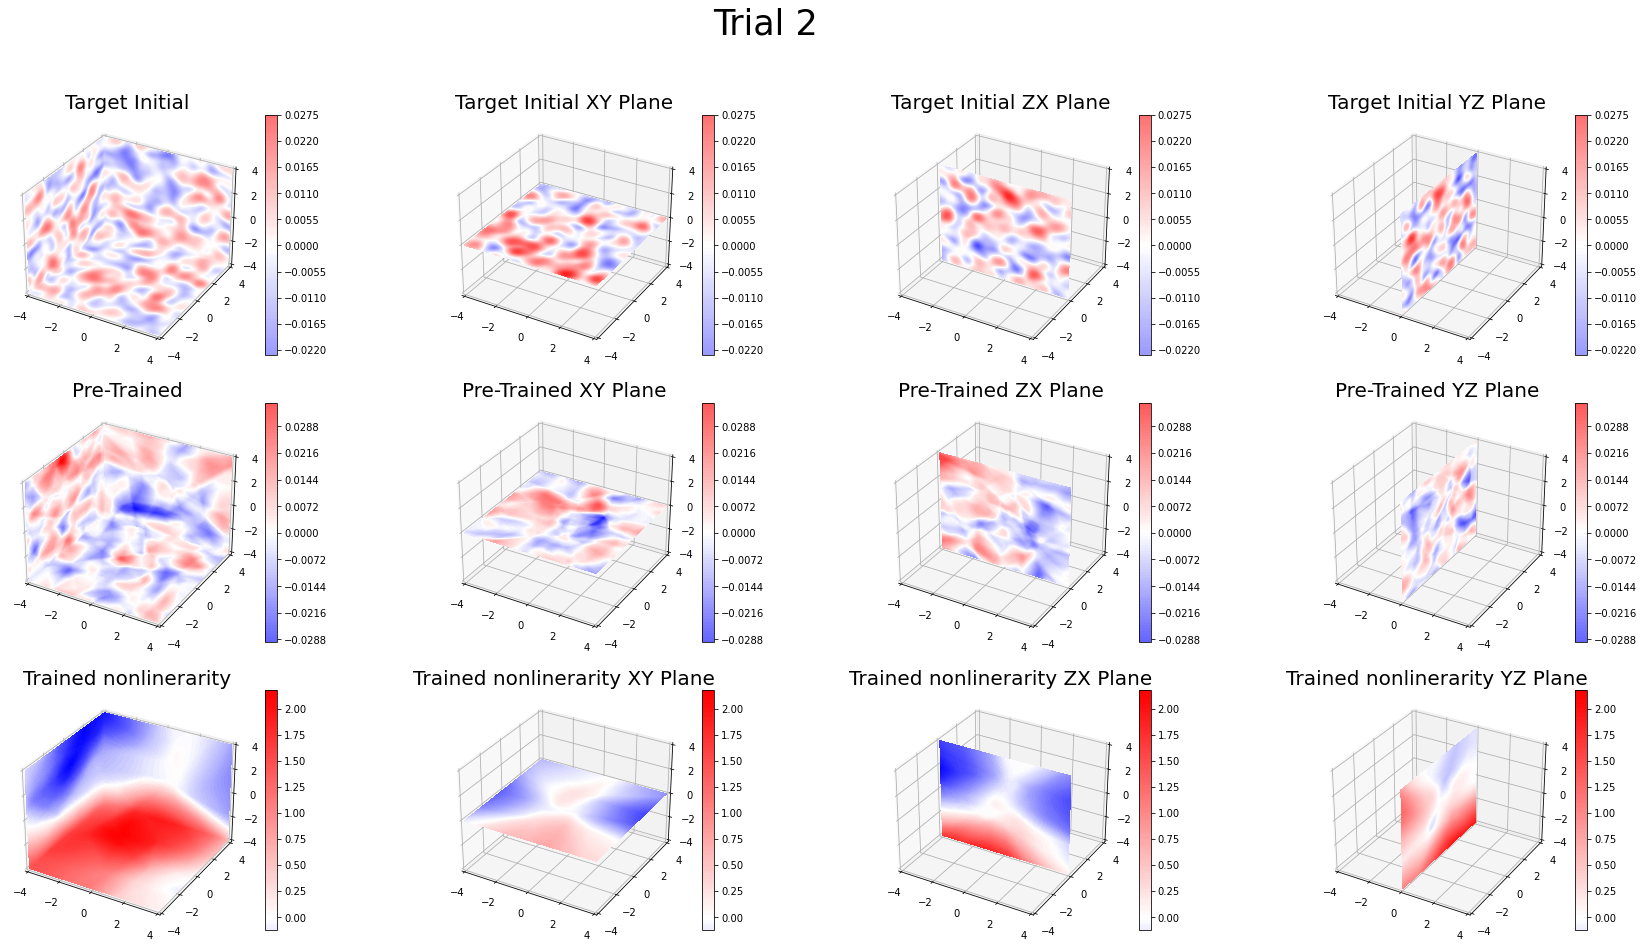

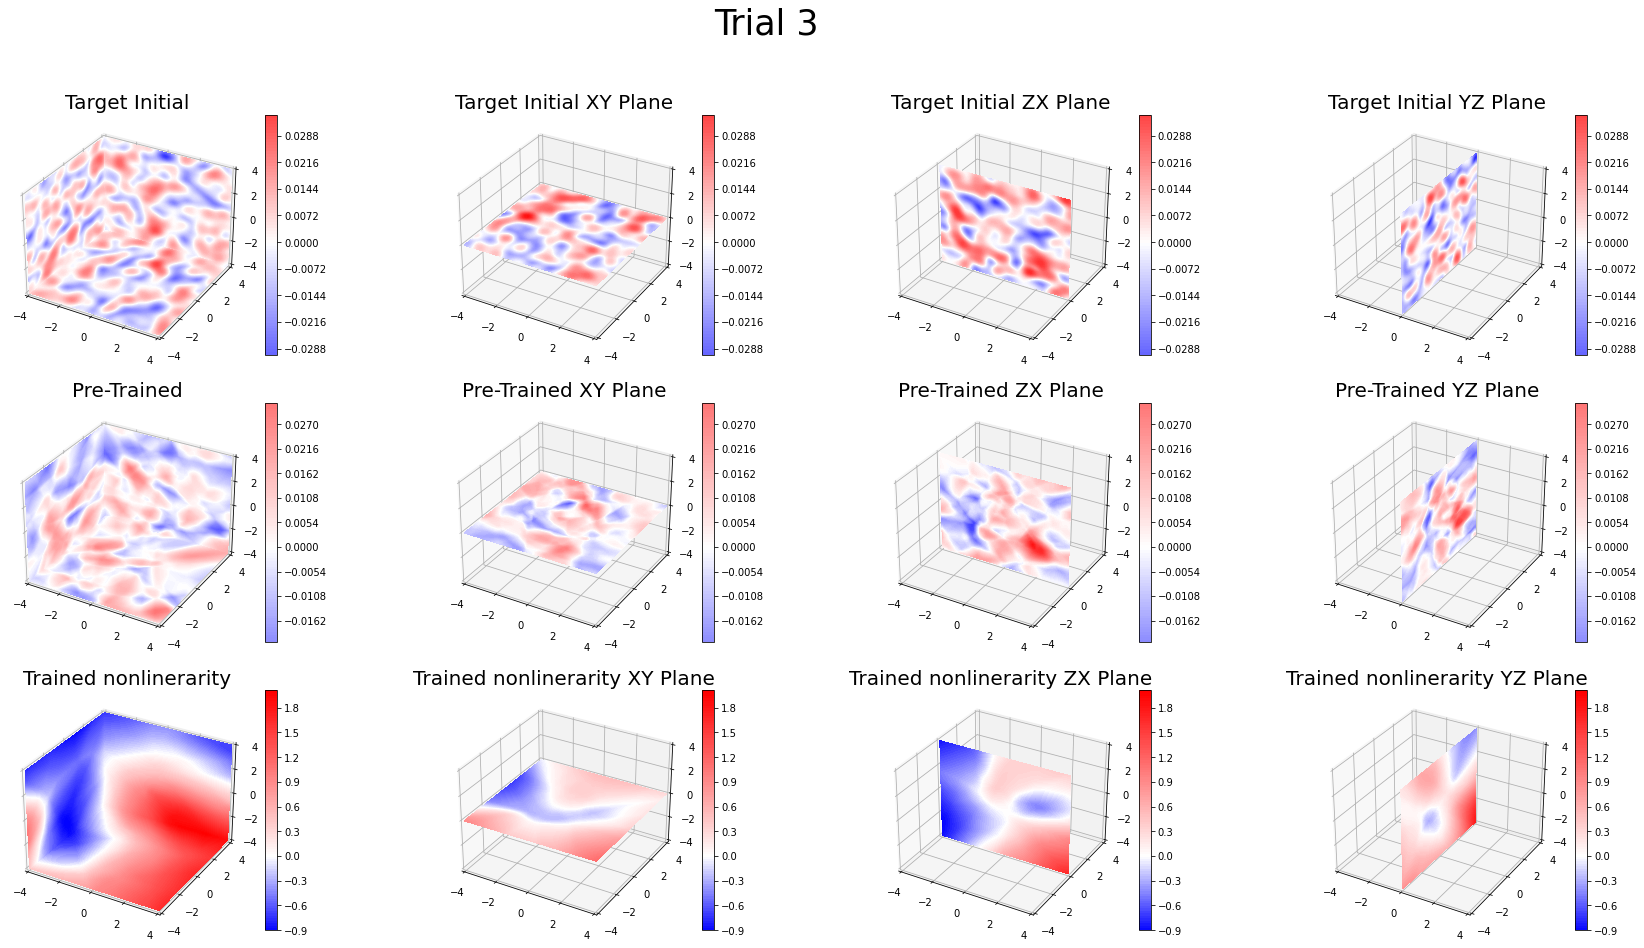

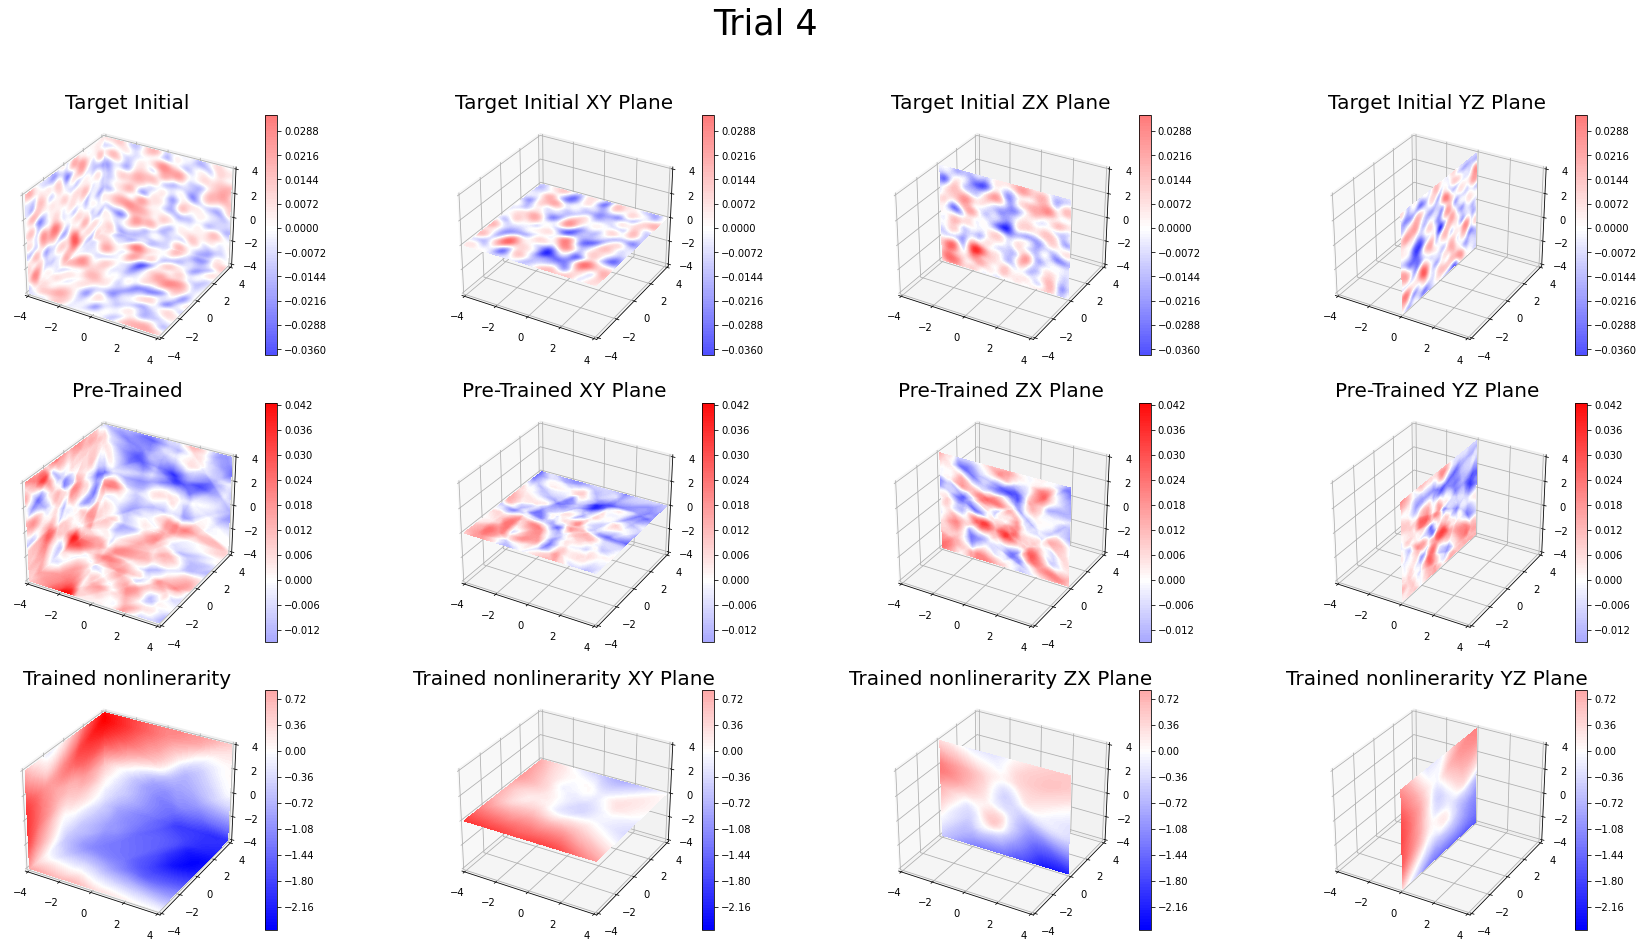

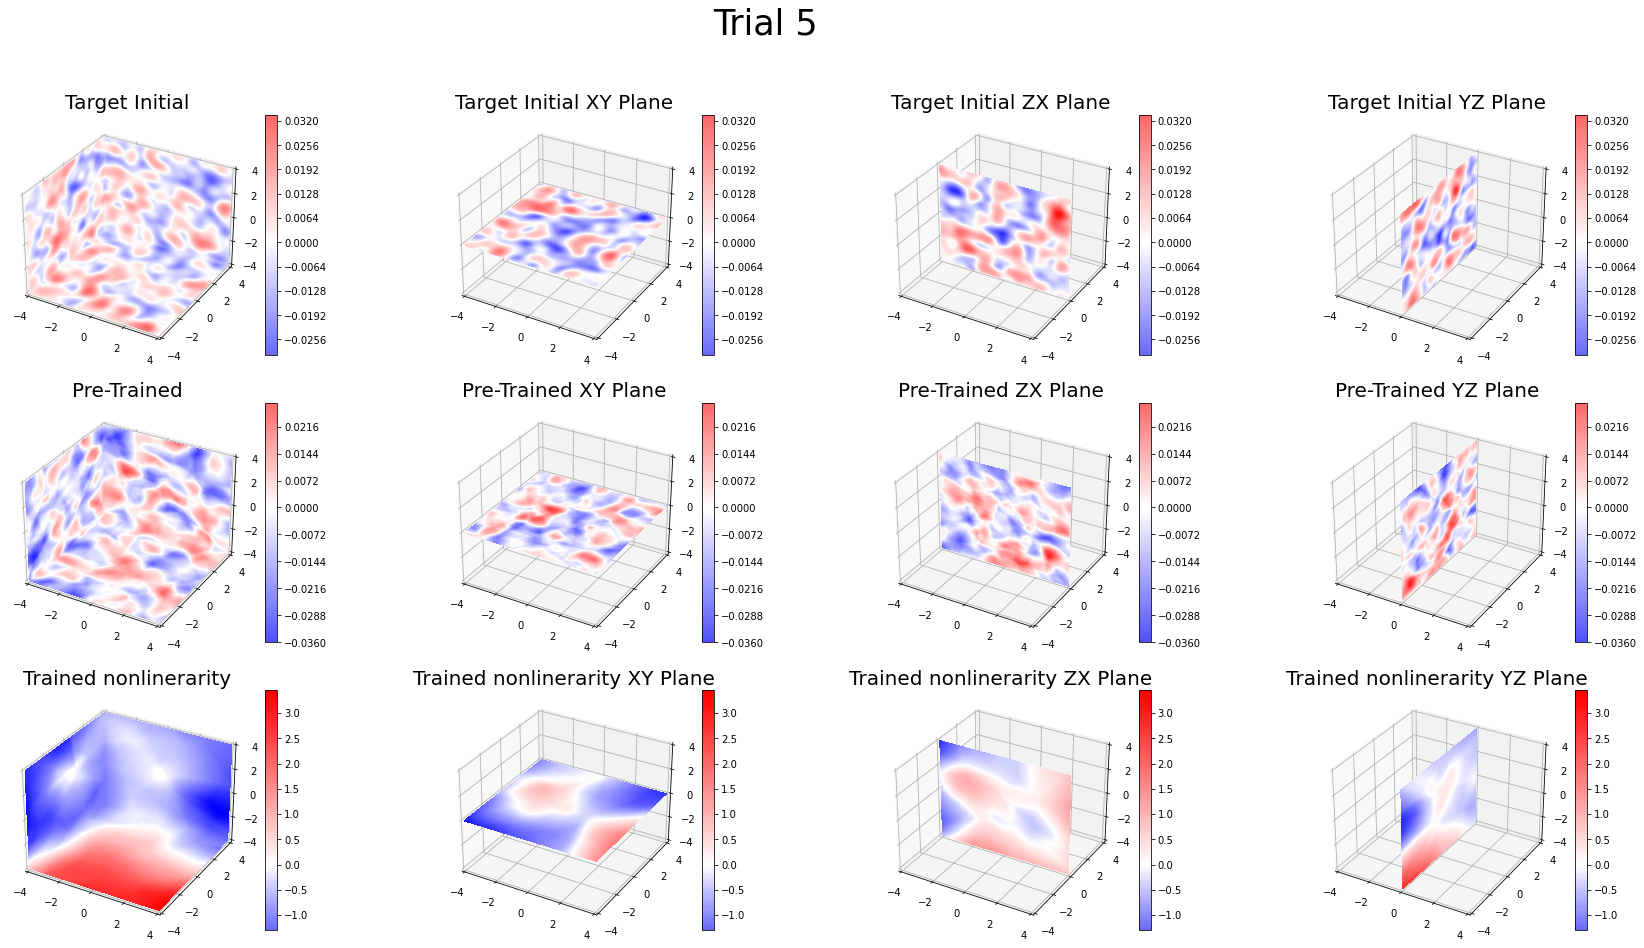

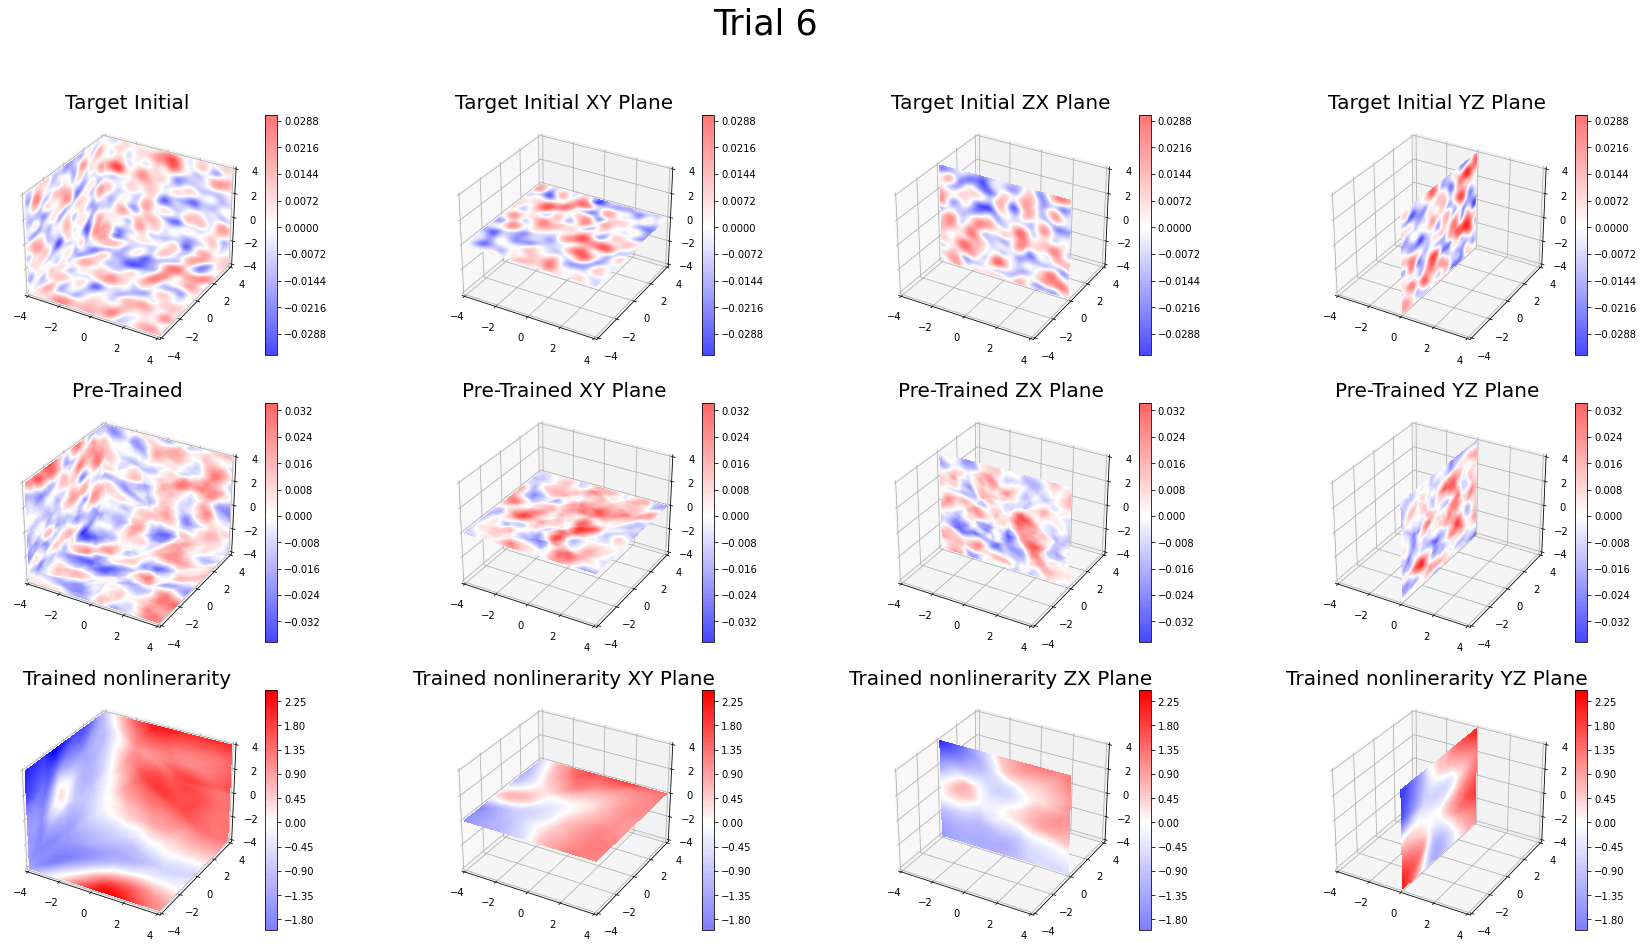

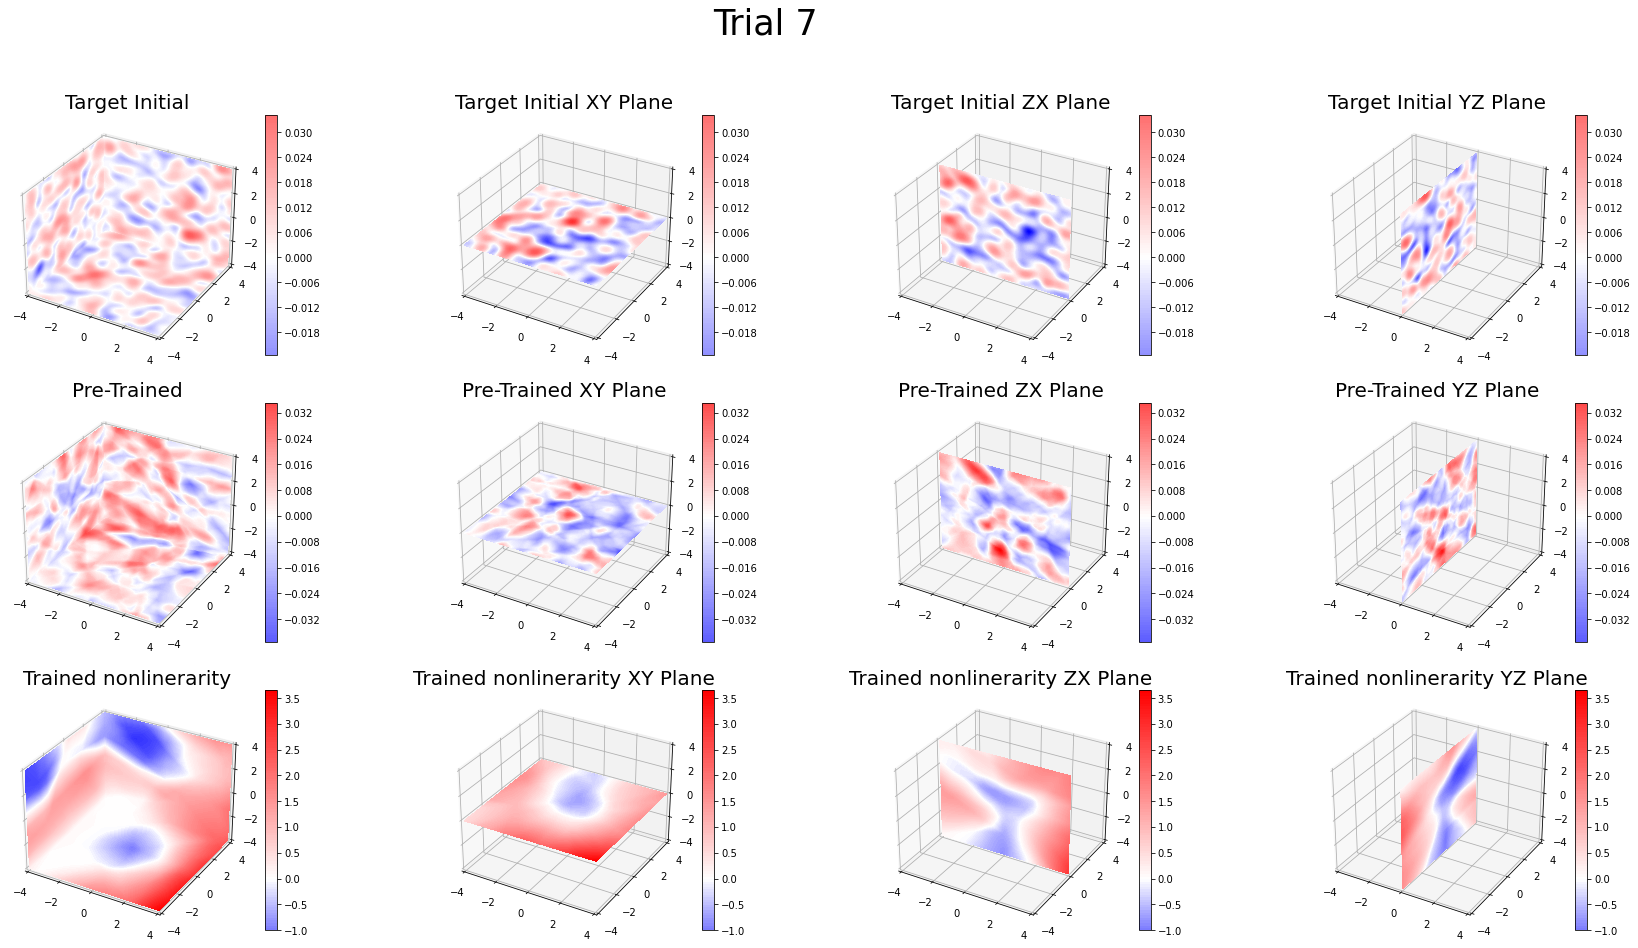

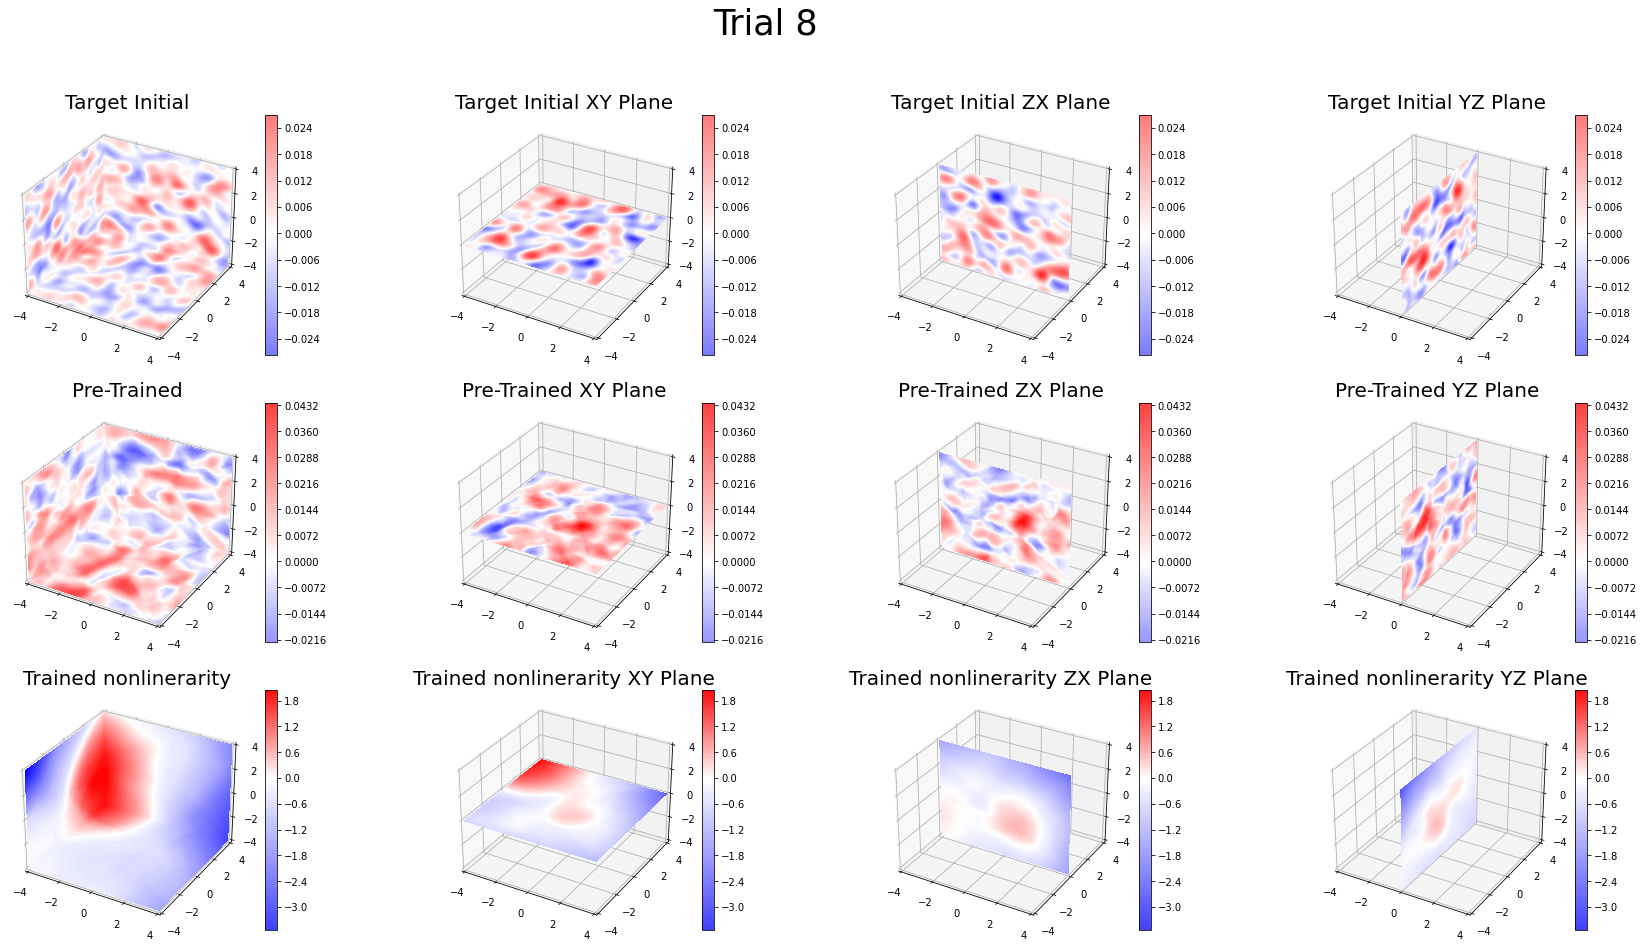

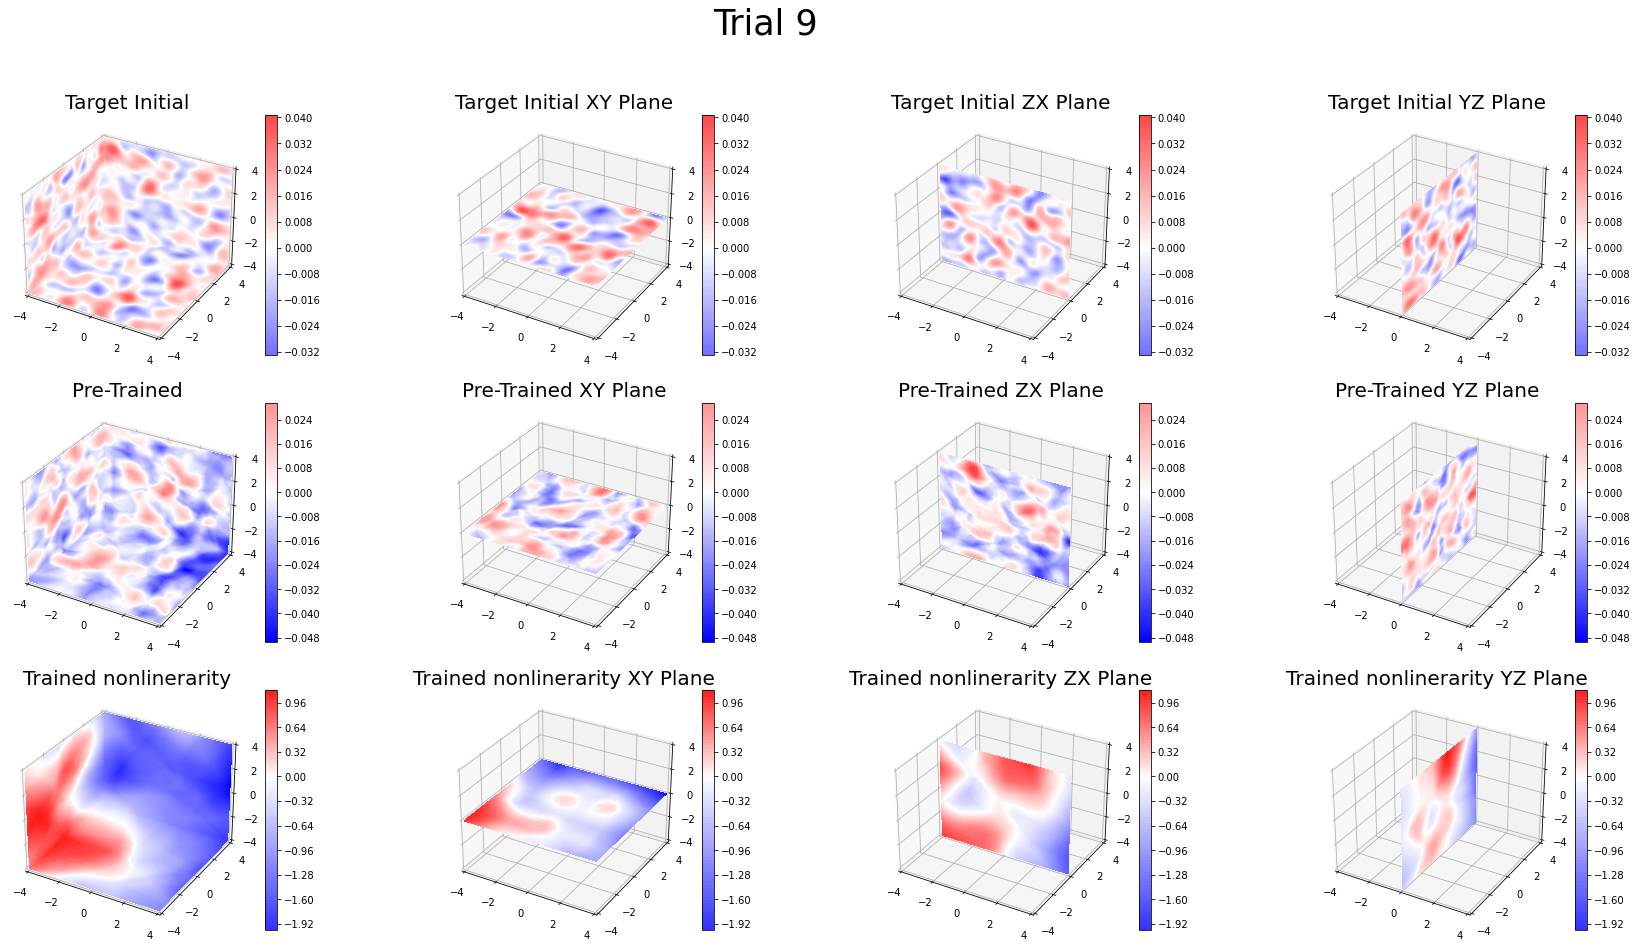

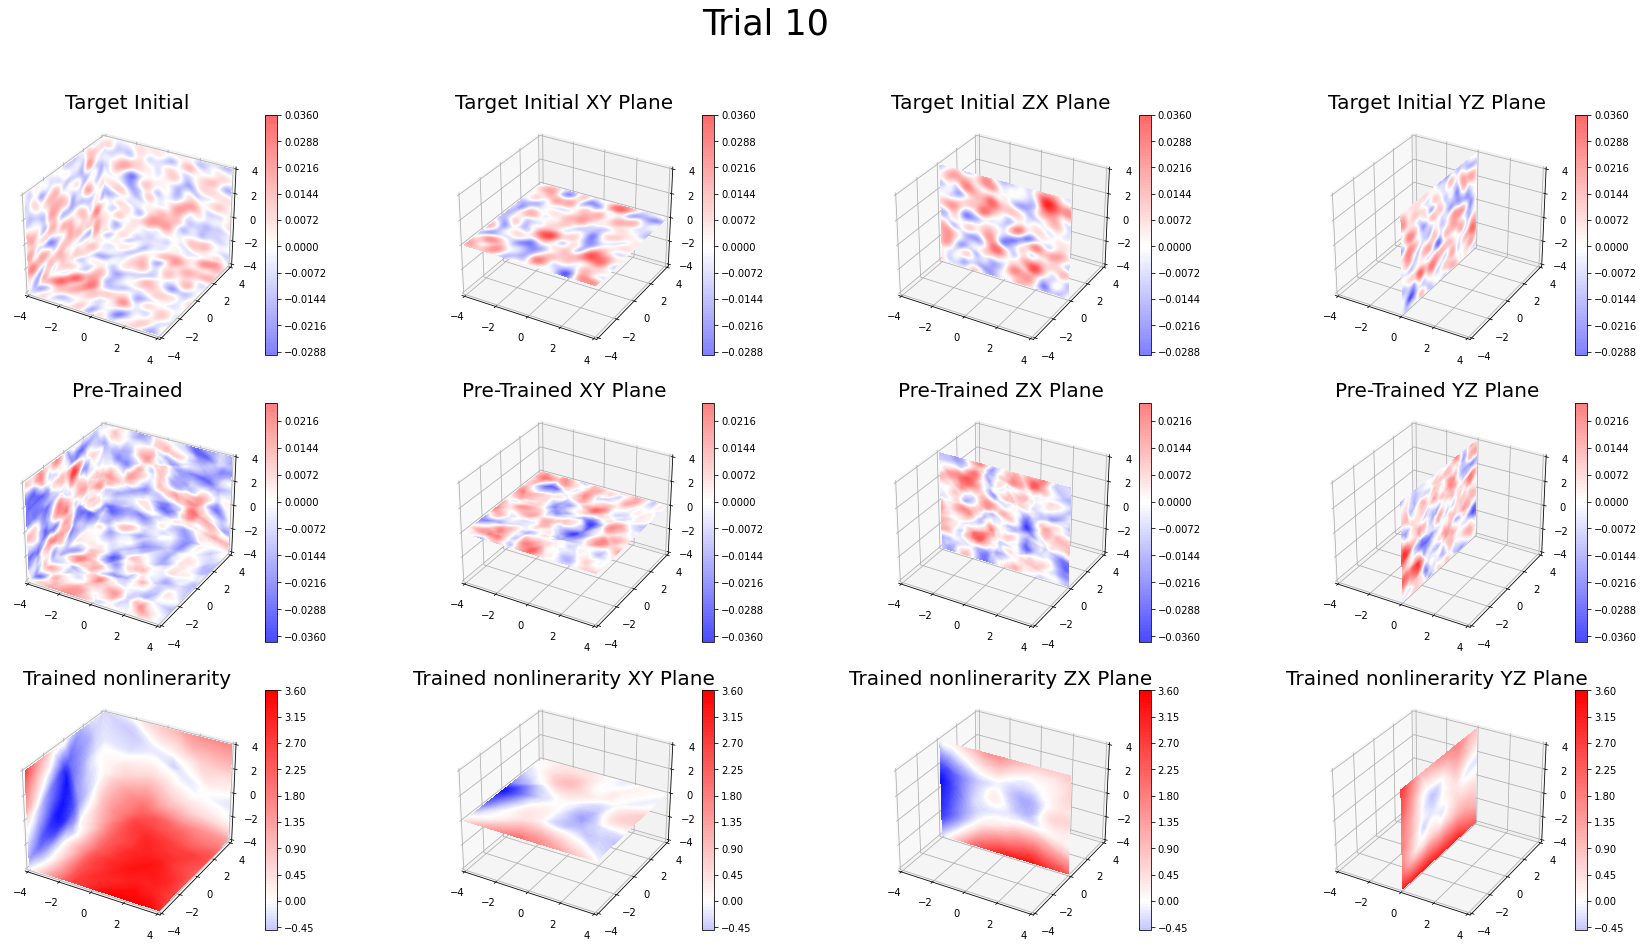

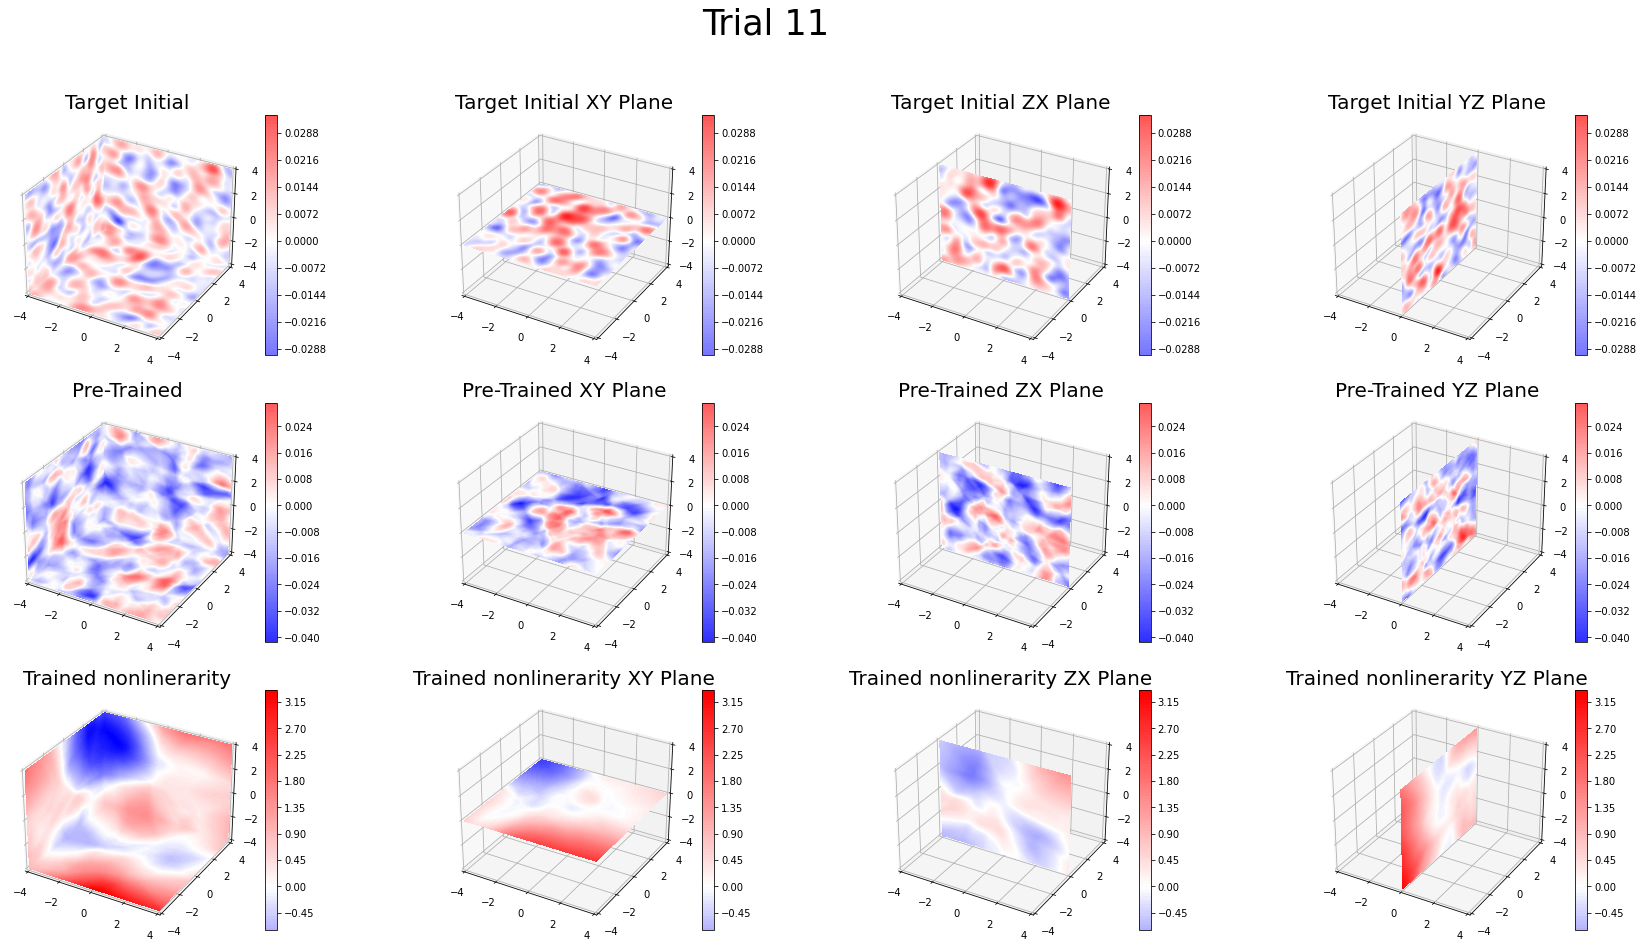

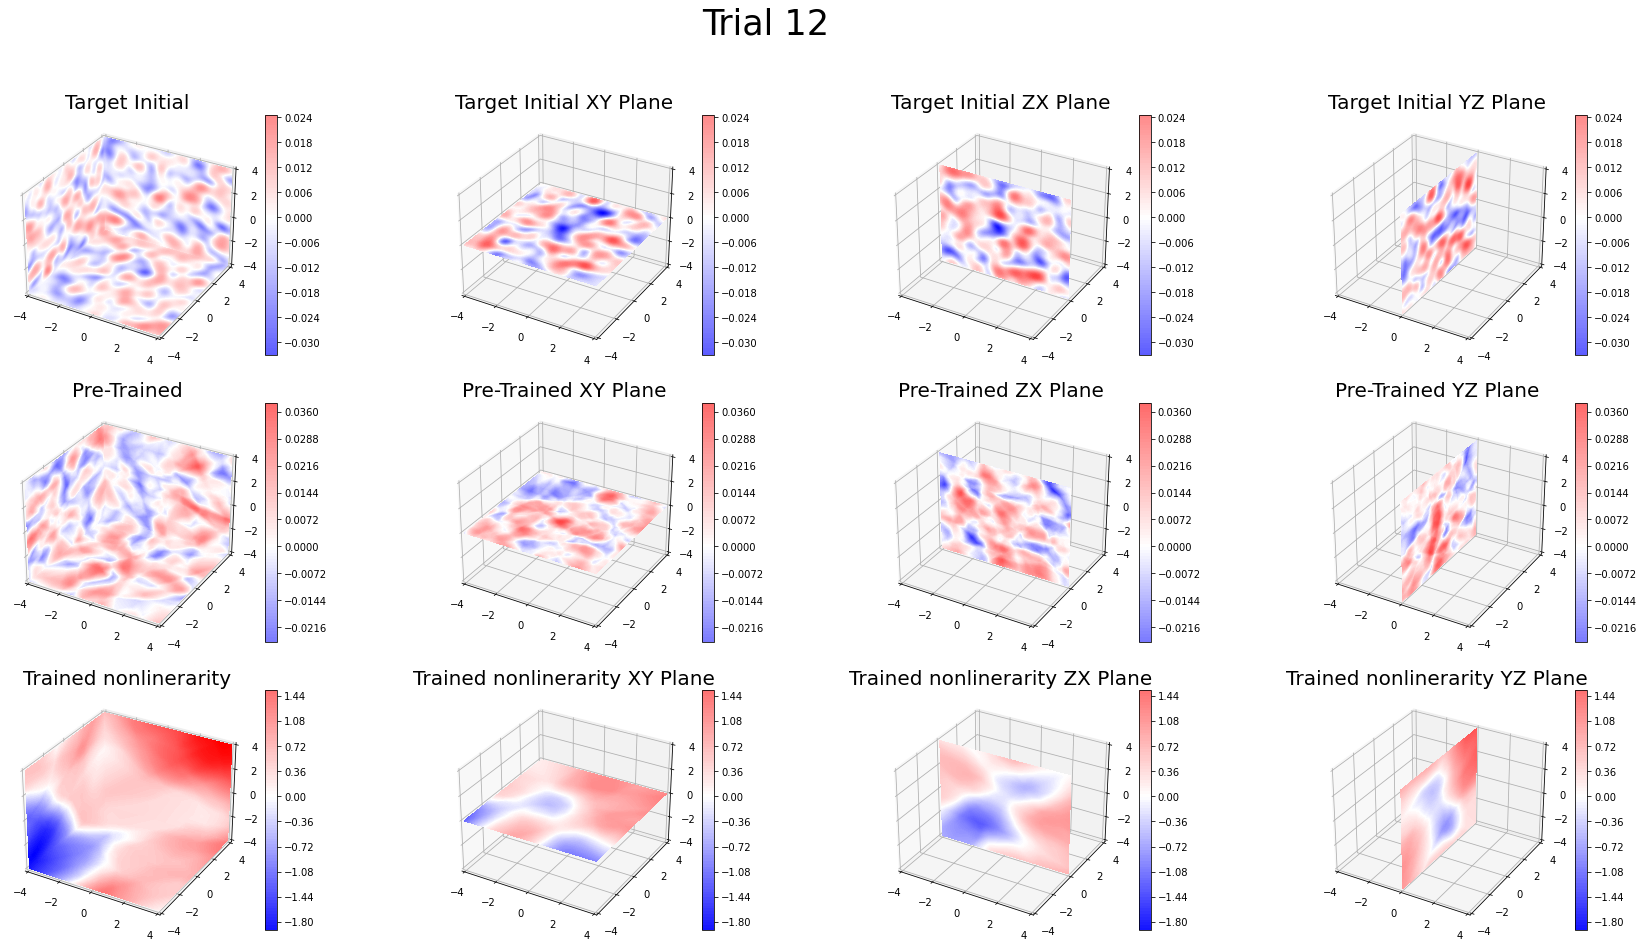

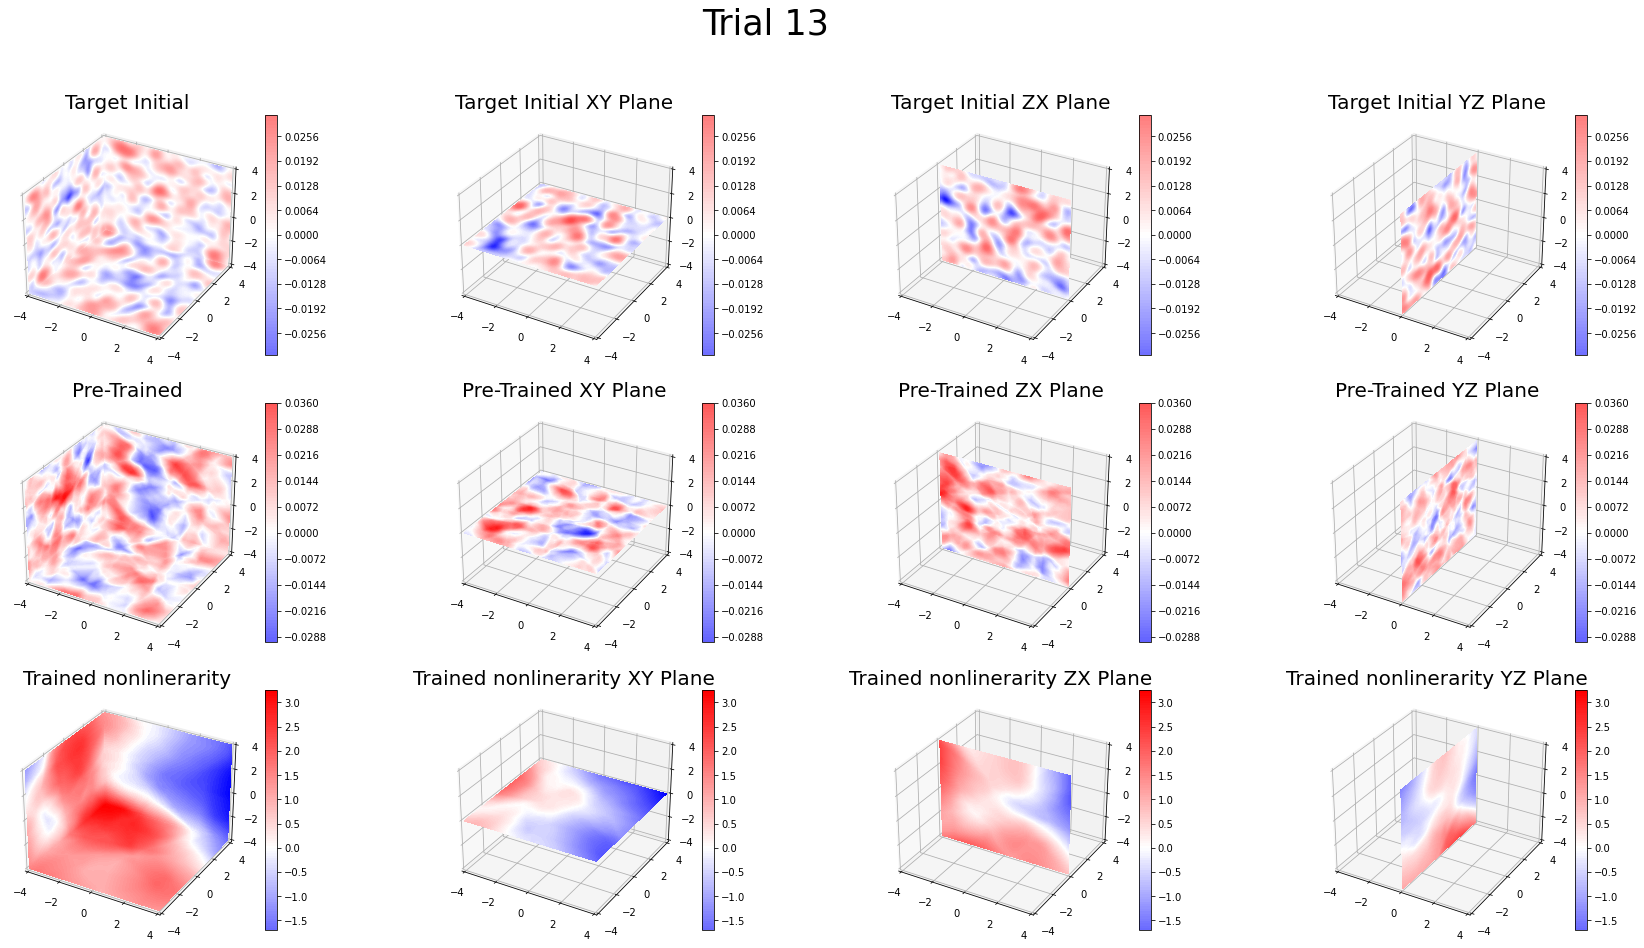

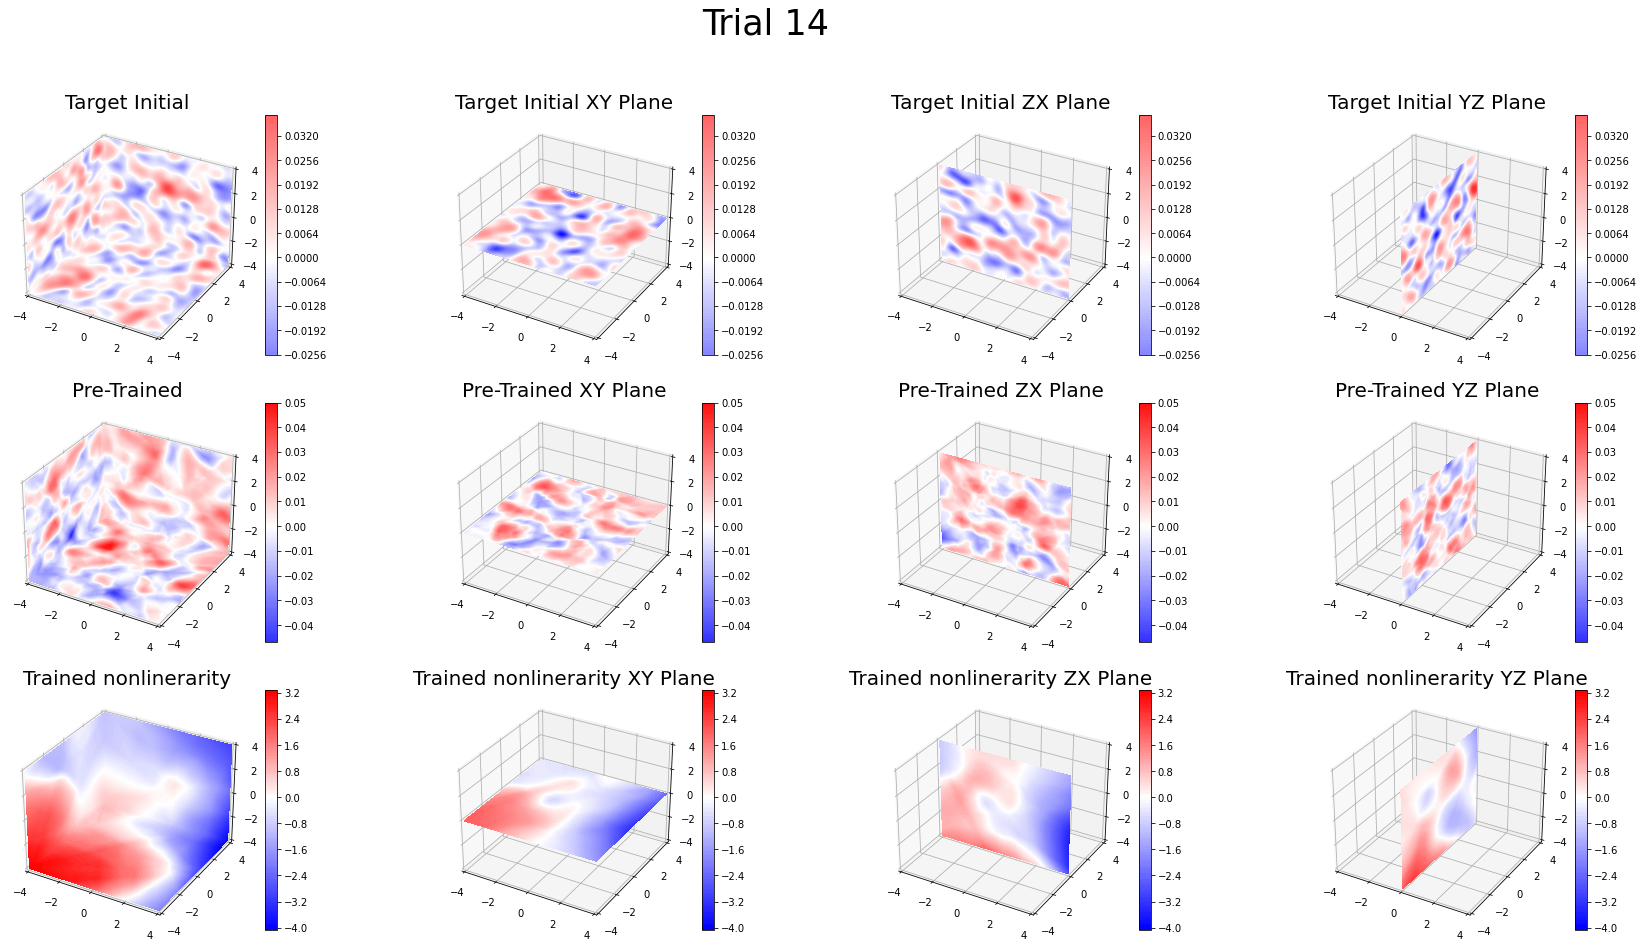

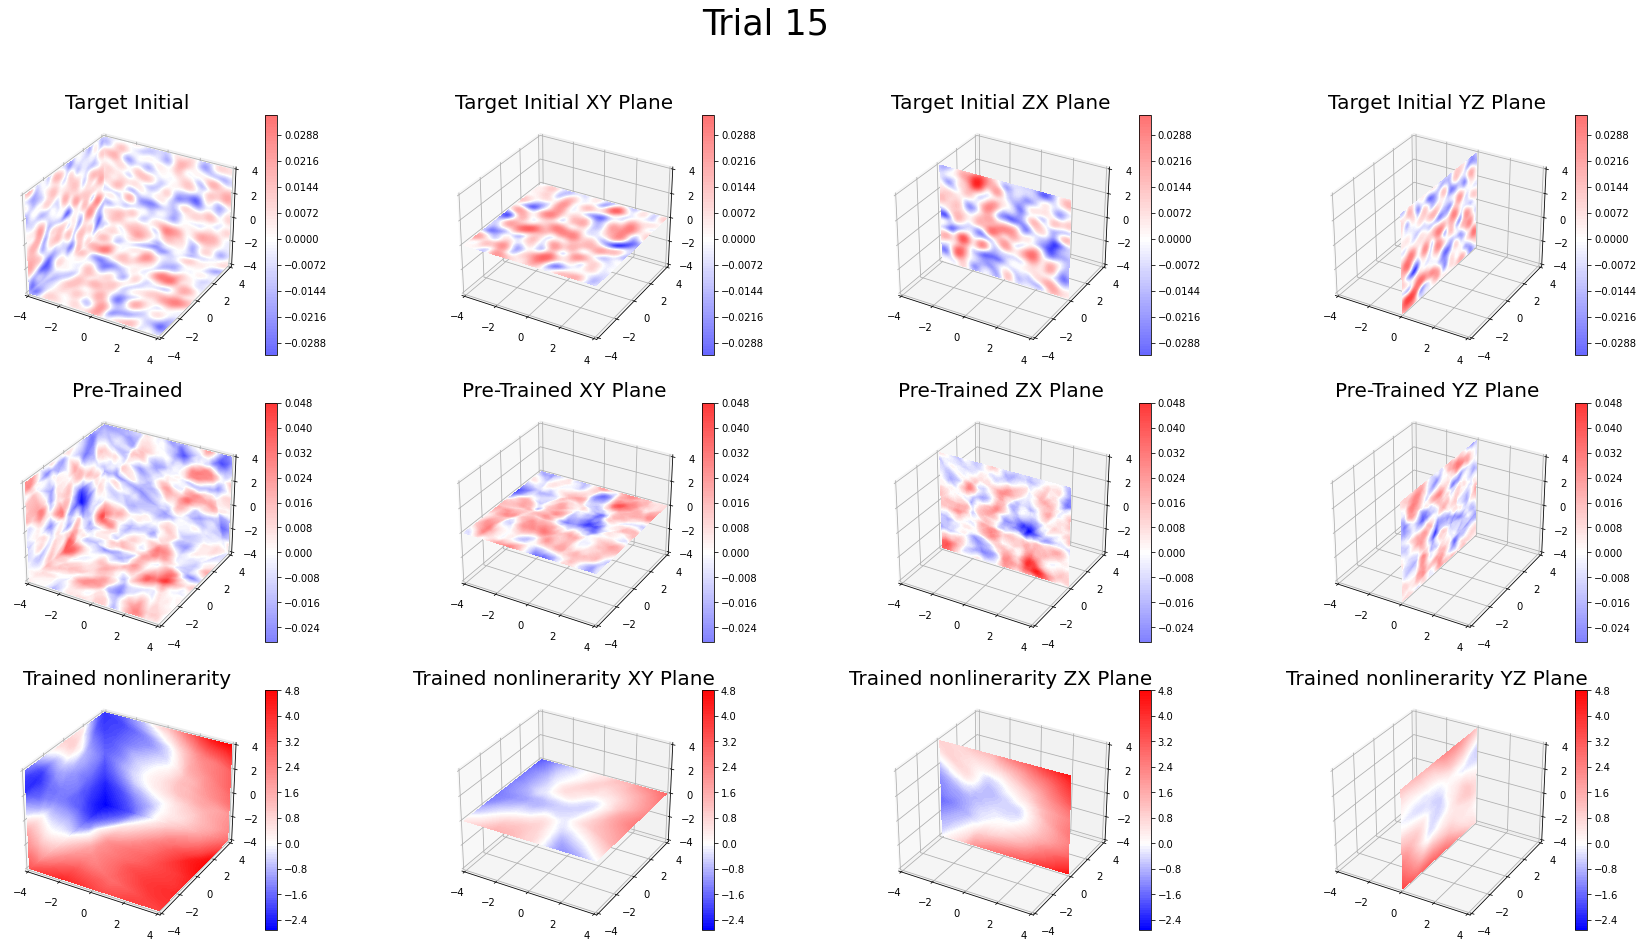

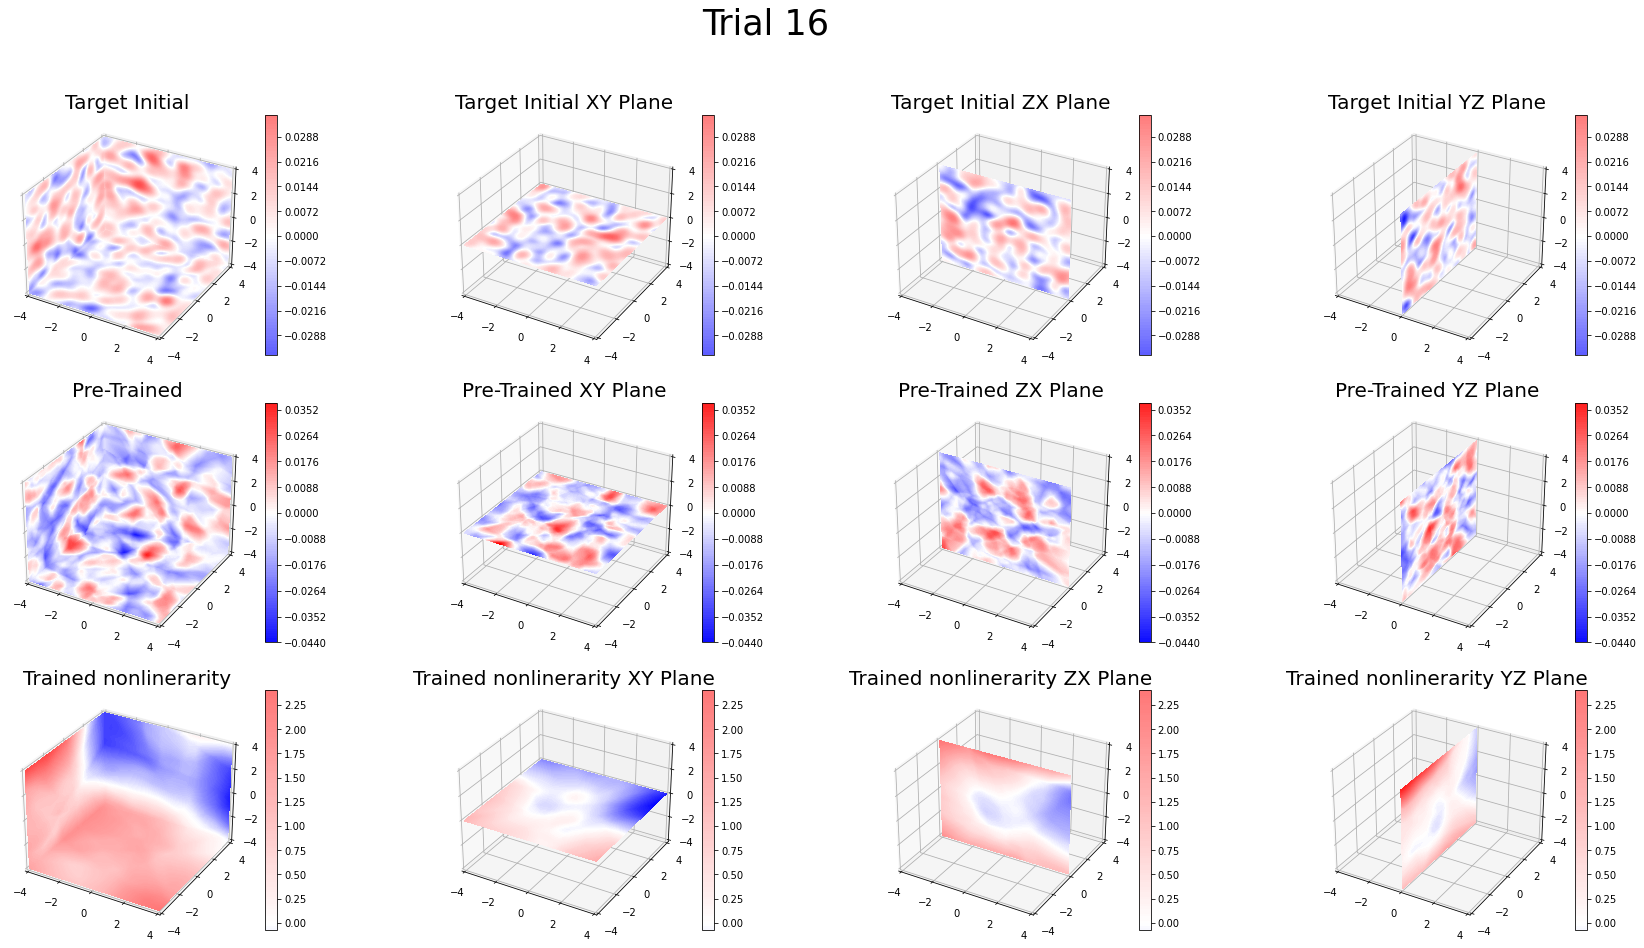

In [13]:
for ii, dr in enumerate(dirs): 
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    seed = int(str(config.seed) + '0011')
    npr = np.random.RandomState(seed=seed)
    
    num = 4
    nb = 81

    x = np.linspace(-num, num, nb)
    y = np.linspace(-num, num, nb)
    z = np.linspace(-num, num, nb)

    xv, yv, zv = np.meshgrid(x, y, z)
    xyz = np.vstack([xv.reshape(-1), yv.reshape(-1), zv.reshape(-1)]).T
    xx, yy = np.meshgrid(x, y)

    mvn = multivariate_normal(mean=[0, 0, 0], cov=[[1 / 9, 0, 0], [0, 1 / 9, 0], [0, 0, 1 / 9]])
    gaussian_kernel = mvn.pdf(xyz).reshape(nb, nb, nb)
    gaussian_kernel /= gaussian_kernel.sum()
    init_unif = npr.uniform(-1, 1, size=(nb, nb, nb))
    targets = convolve(init_unif, gaussian_kernel, mode='same').reshape(-1, 1)
    target_grid = np.append(xyz, targets, axis=1)
    
    target_xy, target_yz, target_zx = make_contour_plane(target_grid, num, nb)
    target_xy_0, target_yz_0, target_zx_0 = make_contour_plane(target_grid, 0, nb)

    model_pretrain = InnerNet(config)
    model_phase1 = InnerNet(config)
    
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])
    model_snapshot = torch.load(config.model_save + config.train.best_model, map_location=torch.device('cpu'))
    
    for key in list(model_snapshot['model'].keys()):
        model_snapshot['model'][key.replace('0', 'inner_net')] = model_snapshot['model'].pop(key)
        
    model_phase1.load_state_dict(model_snapshot["model"], strict=True)    
    
    model_pretrain.eval()
    model_phase1.eval()
    
    out_pretrain = model_pretrain.inner_net(torch.Tensor(xyz))
    out_phase1 = model_phase1.inner_net(torch.Tensor(xyz))
    
    innernet_pretrain = np.append(xyz, out_pretrain.data.numpy(), axis=1)
    innernet_phase1 = np.append(xyz, out_phase1.data.numpy(), axis=1)
    
    pretrain_xy, pretrain_yz, pretrain_zx = make_contour_plane(innernet_pretrain, num, nb)
    pretrain_xy_0, pretrain_yz_0, pretrain_zx_0 = make_contour_plane(innernet_pretrain, 0, nb)
    
    phase1_xy, phase1_yz, phase1_zx = make_contour_plane(innernet_phase1, num, nb)
    phase1_xy_0, phase1_yz_0, phase1_zx_0 = make_contour_plane(innernet_phase1, 0, nb)
    
##################################################################################################   
    f = plt.figure(figsize=(30, 15))
    
    cmax = max(targets)
    cmin = min(targets)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    
    ax1 = f.add_subplot(3, 4, 1, projection='3d')
    im1 = ax1.contourf(xx, yy, target_xy,100, zdir='z', offset=-num,cmap='bwr', norm=norm)
    ax1.contourf(xx, target_zx, yy,100, zdir='y', offset=num,cmap='bwr', norm=norm)
    ax1.contourf(target_yz, xx, yy,100, zdir='x', offset=-num,cmap='bwr', norm=norm)
    ax1.set_xlim([-4, 4])
    ax1.set_ylim([-4, 4])
    ax1.set_zlim([-4, 4])
    ax1.set_title("Target Initial", fontsize = 20)
    f.colorbar(im1)

    ax2 = f.add_subplot(3, 4, 2, projection='3d')
    ax2.contourf(xx, yy, target_xy_0,100, zdir='z', offset=0,cmap='bwr', norm=norm)
    ax2.set_xlim([-4, 4])
    ax2.set_ylim([-4, 4])
    ax2.set_zlim([-4, 4])
    ax2.set_title("Target Initial XY Plane", fontsize = 20)
    f.colorbar(im1)

    ax3 = f.add_subplot(3, 4, 3, projection='3d')
    ax3.contourf(xx, target_zx_0, yy,100, zdir='y', offset=0,cmap='bwr', norm=norm)
    ax3.set_xlim([-4, 4])
    ax3.set_ylim([-4, 4])
    ax3.set_zlim([-4, 4])
    ax3.set_title("Target Initial ZX Plane", fontsize = 20)
    f.colorbar(im1)
    
    ax4 = f.add_subplot(3, 4, 4, projection='3d')
    ax4.contourf(target_yz_0, xx, yy,100, zdir='x', offset=0,cmap='bwr', norm=norm)
    ax4.set_xlim([-4, 4])
    ax4.set_ylim([-4, 4])
    ax4.set_zlim([-4, 4])
    ax4.set_title("Target Initial YZ Plane", fontsize = 20)
    f.colorbar(im1)
    
##################################################################################################
    cmax = max(out_pretrain)
    cmin = min(out_pretrain)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    
    ax5 = f.add_subplot(3, 4, 5, projection='3d')
    im2 = ax5.contourf(xx, yy, pretrain_xy,100, zdir='z', offset=-num,cmap='bwr', norm=norm)
    ax5.contourf(xx, pretrain_zx, yy,100, zdir='y', offset=num,cmap='bwr', norm=norm)
    ax5.contourf(pretrain_yz, xx, yy,100, zdir='x', offset=-num,cmap='bwr', norm=norm)
    ax5.set_xlim([-4, 4])
    ax5.set_ylim([-4, 4])
    ax5.set_zlim([-4, 4])
    ax5.set_title("Pre-Trained", fontsize = 20)
    f.colorbar(im2)

    ax6 = f.add_subplot(3, 4, 6, projection='3d')
    ax6.contourf(xx, yy, pretrain_xy_0,100, zdir='z', offset=0,cmap='bwr', norm=norm)
    ax6.set_xlim([-4, 4])
    ax6.set_ylim([-4, 4])
    ax6.set_zlim([-4, 4])
    ax6.set_title("Pre-Trained XY Plane", fontsize = 20)
    f.colorbar(im2)

    ax7 = f.add_subplot(3, 4, 7, projection='3d')
    ax7.contourf(xx, pretrain_zx_0, yy,100, zdir='y', offset=0,cmap='bwr', norm=norm)
    ax7.set_xlim([-4, 4])
    ax7.set_ylim([-4, 4])
    ax7.set_zlim([-4, 4])
    ax7.set_title("Pre-Trained ZX Plane", fontsize = 20)
    f.colorbar(im2)

    ax8 = f.add_subplot(3, 4, 8, projection='3d')
    ax8.contourf(pretrain_yz_0, xx, yy,100, zdir='x', offset=0,cmap='bwr', norm=norm)
    ax8.set_xlim([-4, 4])
    ax8.set_ylim([-4, 4])
    ax8.set_zlim([-4, 4])
    ax8.set_title("Pre-Trained YZ Plane", fontsize = 20)
    f.colorbar(im2)
    
##################################################################################################3
    cmax = max(out_phase1)
    cmin = min(out_phase1)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    
    ax9 = f.add_subplot(3, 4, 9, projection='3d')
    im3 = ax9.contourf(xx, yy, phase1_xy,100, zdir='z', offset=-num,cmap='bwr', norm=norm)
    ax9.contourf(xx, phase1_zx, yy,100, zdir='y', offset=num,cmap='bwr', norm=norm)
    ax9.contourf(phase1_yz, xx, yy,100, zdir='x', offset=-num,cmap='bwr', norm=norm)
    ax9.set_xlim([-4, 4])
    ax9.set_ylim([-4, 4])
    ax9.set_zlim([-4, 4])
    ax9.set_title("Trained nonlinerarity", fontsize = 20)
    f.colorbar(im3)

    ax10 = f.add_subplot(3, 4, 10, projection='3d')
    ax10.contourf(xx, yy, phase1_xy_0,100, zdir='z', offset=0,cmap='bwr', norm=norm)
    ax10.set_xlim([-4, 4])
    ax10.set_ylim([-4, 4])
    ax10.set_zlim([-4, 4])
    ax10.set_title("Trained nonlinerarity XY Plane", fontsize = 20)
    f.colorbar(im3)

    ax11 = f.add_subplot(3, 4, 11, projection='3d')
    ax11.contourf(xx, phase1_zx_0, yy,100, zdir='y', offset=0,cmap='bwr', norm=norm)
    ax11.set_xlim([-4, 4])
    ax11.set_ylim([-4, 4])
    ax11.set_zlim([-4, 4])
    ax11.set_title("Trained nonlinerarity ZX Plane", fontsize = 20)
    f.colorbar(im3)

    ax12 = f.add_subplot(3, 4, 12, projection='3d')
    ax12.contourf(phase1_yz_0, xx, yy,100, zdir='x', offset=0,cmap='bwr', norm=norm)
    ax12.set_xlim([-4, 4])
    ax12.set_ylim([-4, 4])
    ax12.set_zlim([-4, 4])
    ax12.set_title("Trained nonlinerarity YZ Plane", fontsize = 20)
    f.colorbar(im3)
    
    f.suptitle(f'Trial {ii+1}', fontsize = 35)
    
f.savefig(f'./arg_3D_{config.model.inner_net}_{config.dataset.name}_visualize_{ii}')

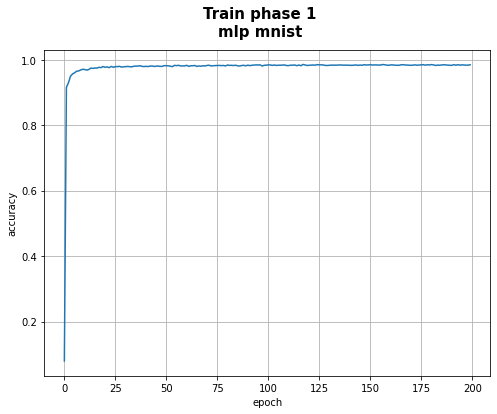

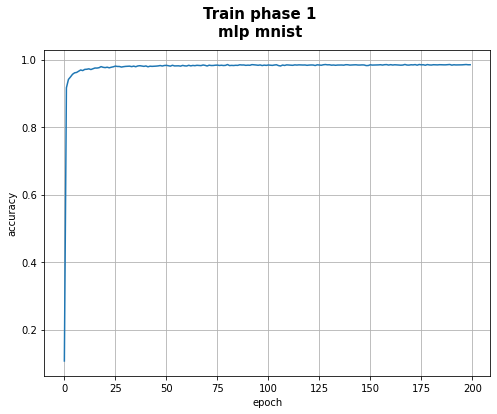

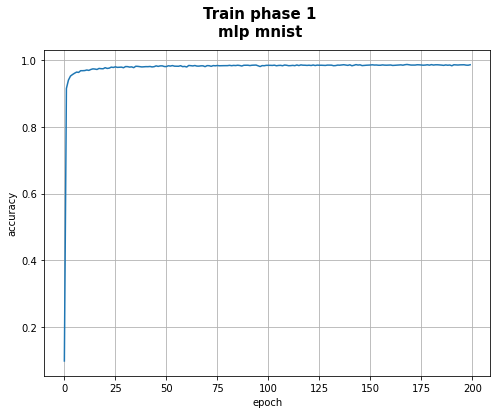

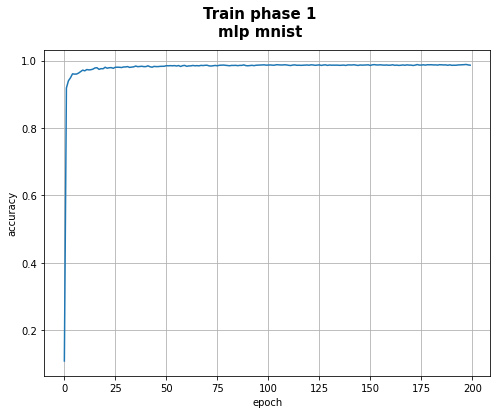

In [31]:
epoch = np.arange(400)
for ii in range(len(dirs_3D)): 
    fig, ax = plt.subplots(figsize=(8,6))
    
    config_file = glob(dirs_3D[ii] + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    phase1_file = glob(dirs_3D[ii] + '/train_stats_phase1.p')[0]
#     phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
#     phase2_data = pickle.load(open(phase2_file, 'rb'))

    ax.plot(phase1_data['val_acc'])
#     ax.plot(epoch, np.hstack([phase1_data['val_acc'], phase2_data['val_acc']]), 'b', lw=1)
    ax.set_xlabel('epoch', fontsize=10)
    ax.set_ylabel('accuracy', fontsize=10)
    ax.grid(True)
    
    fig.suptitle(f'Train phase 1\n{config.model.inner_net} {config.dataset.name}',fontweight ="bold", fontsize = 15)
    fig.show()
    fig.savefig(f'./arg_3D_{config.model.inner_net}_{config.dataset.name}_LearningCurve_{ii}')

In [56]:
dirs_3D_test = glob("../exp/3D_Arg_Test/*")
dirs_3D_test.sort(key=os.path.abspath)
dirs_3D_test = dirs_3D_test[3:12]
dirs_3D_test

['../exp/3D_Arg_Test/ComplexNeuronMLP_1_mnist_0257',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_2_mnist_0257',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_3_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_4_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_5_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_6_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_7_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_8_mnist_0258',
 '../exp/3D_Arg_Test/ComplexNeuronMLP_9_mnist_0258']

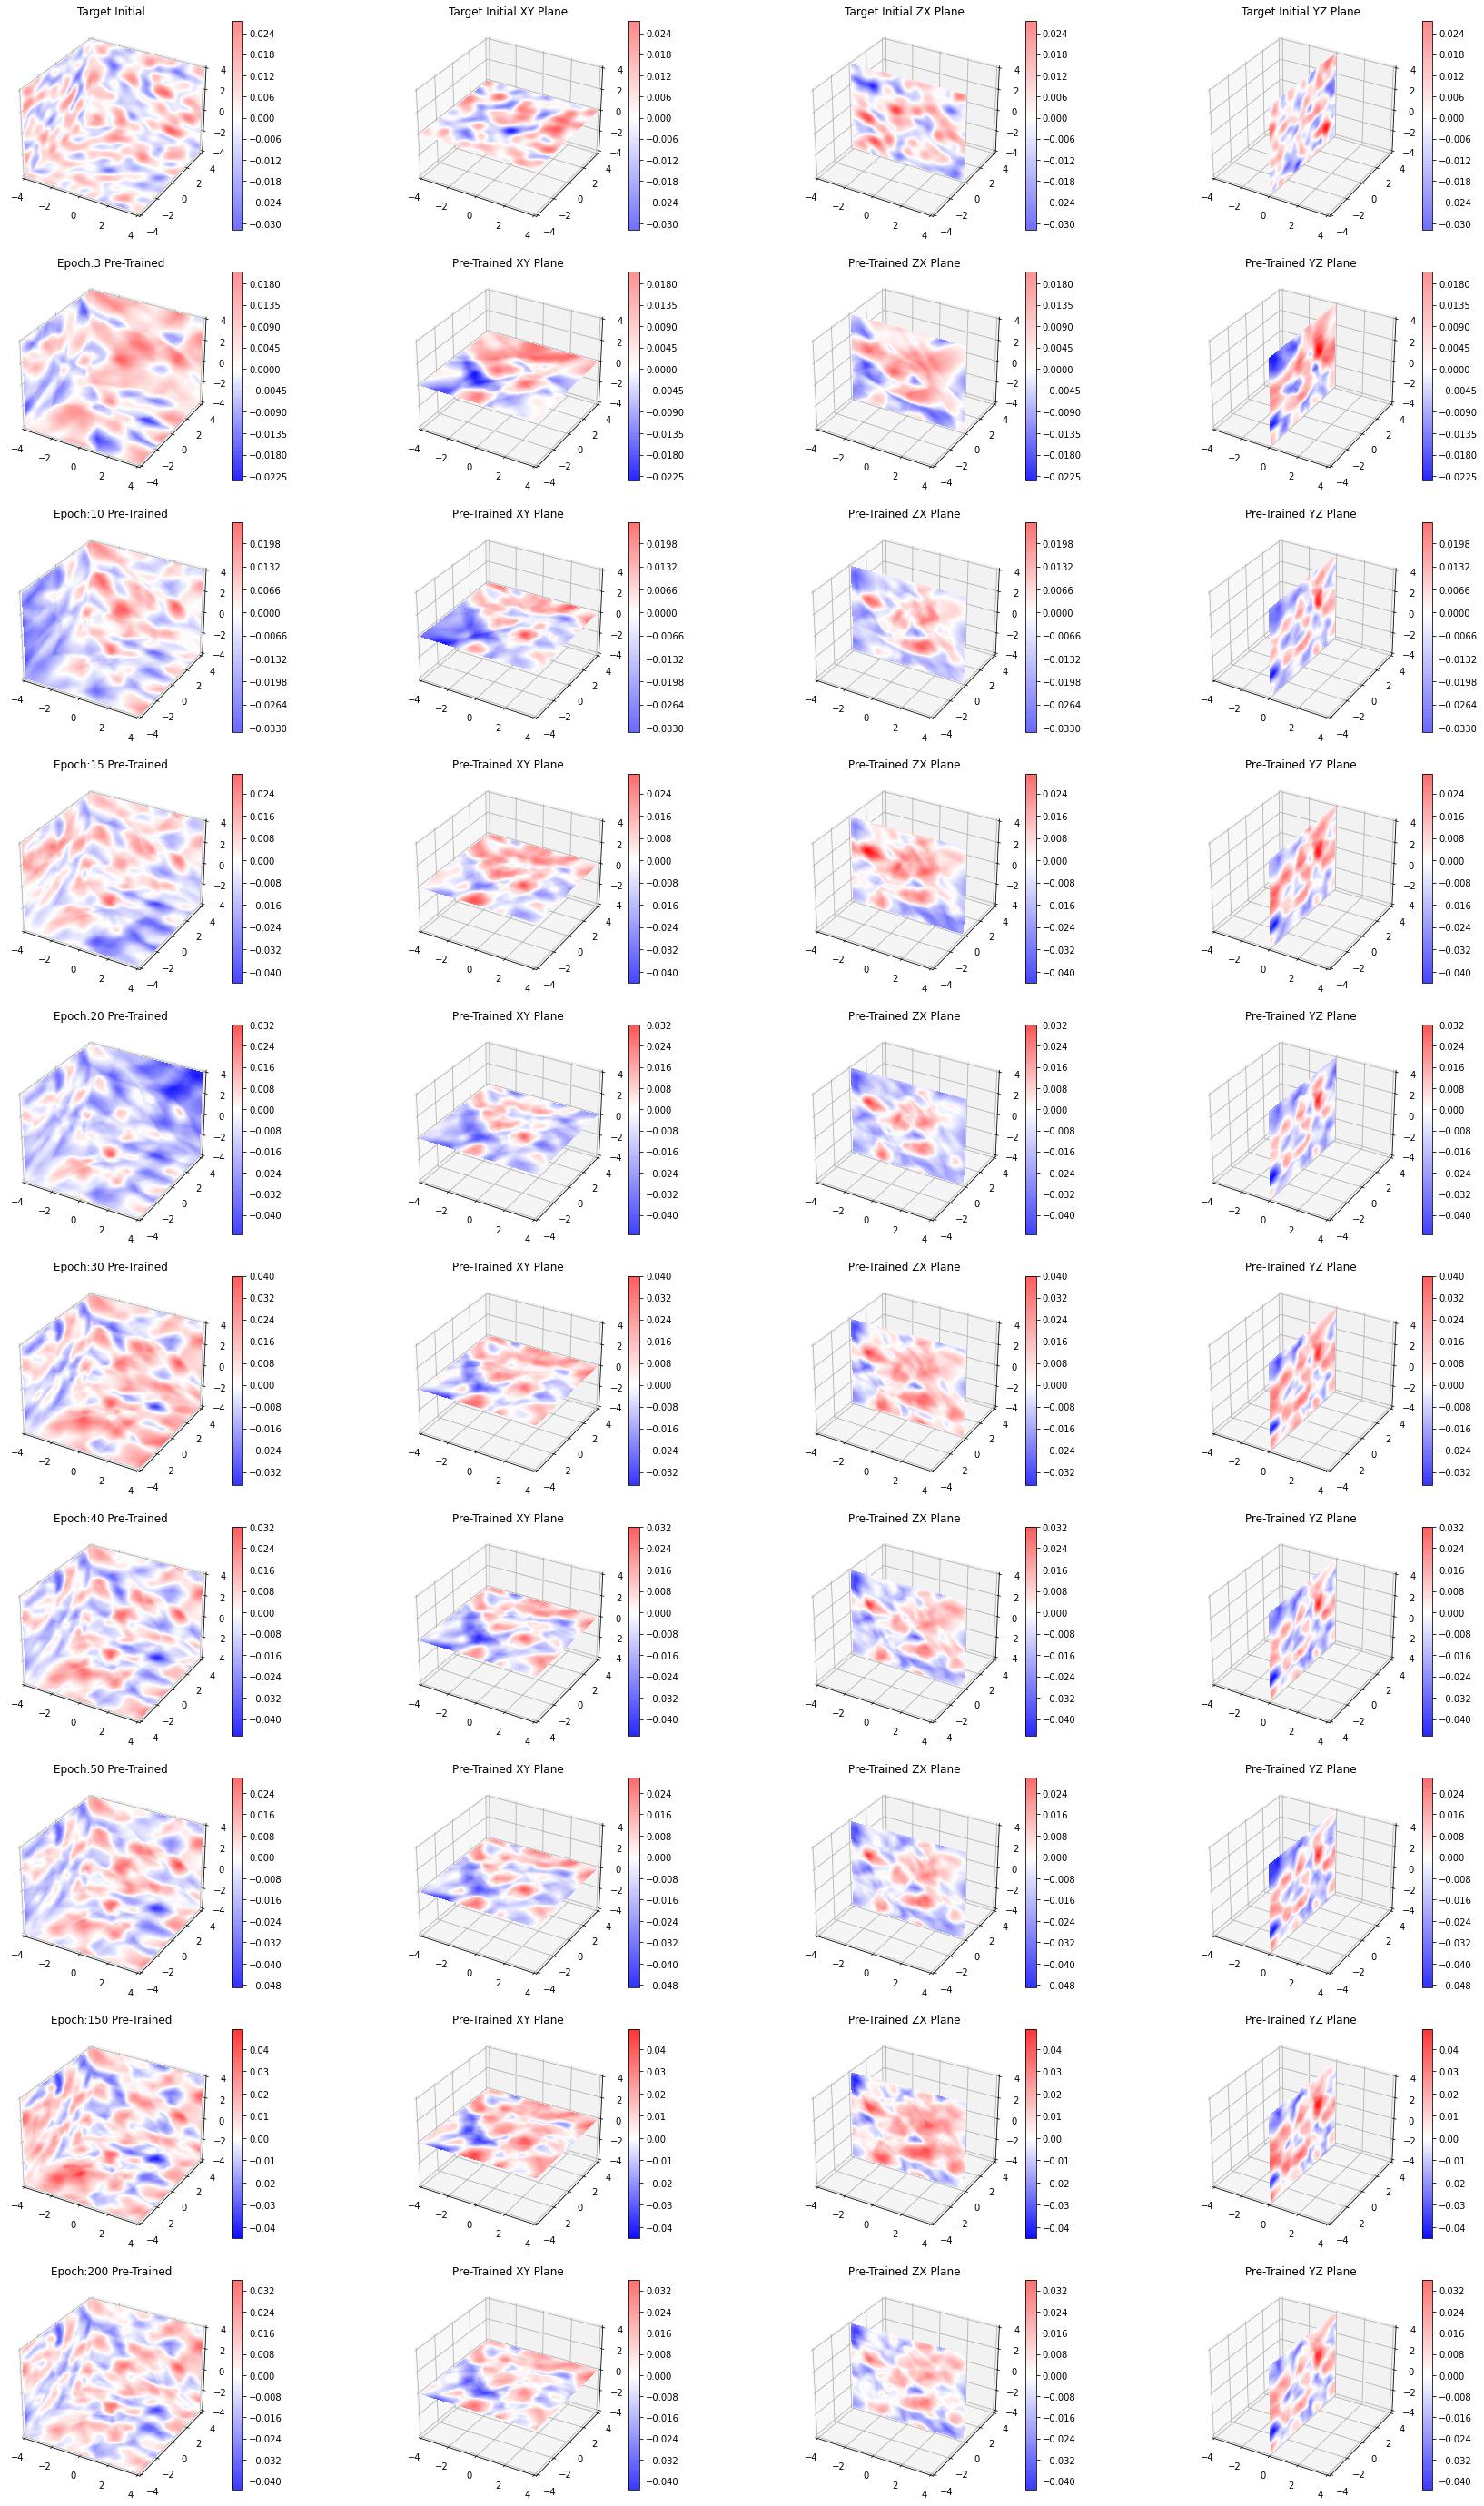

In [57]:
l=len(dirs_3D_test)+1

config_file = glob(dirs_3D[0] + '/*.yaml')[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

seed = int(str(config.seed) + '0011')
npr = np.random.RandomState(seed=seed)

num = 4
nb = 81

x = np.linspace(-num, num, nb)
y = np.linspace(-num, num, nb)
z = np.linspace(-num, num, nb)

xv, yv, zv = np.meshgrid(x, y, z)
xyz = np.vstack([xv.reshape(-1), yv.reshape(-1), zv.reshape(-1)]).T
xx, yy = np.meshgrid(x, y)

mvn = multivariate_normal(mean=[0, 0, 0], cov=[[1 / 9, 0, 0], [0, 1 / 9, 0], [0, 0, 1 / 9]])
gaussian_kernel = mvn.pdf(xyz).reshape(nb, nb, nb)
gaussian_kernel /= gaussian_kernel.sum()
init_unif = npr.uniform(-1, 1, size=(nb, nb, nb))
targets = convolve(init_unif, gaussian_kernel, mode='same').reshape(-1, 1)
target_grid = np.append(xyz, targets, axis=1)

target_xy, target_yz, target_zx = make_contour_plane(target_grid, num, nb)
target_xy_0, target_yz_0, target_zx_0 = make_contour_plane(target_grid, 0, nb)

cmax = max(targets)
cmin = min(targets)
norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)

f = plt.figure(figsize=(30,5*l))

ax1 = f.add_subplot(l, 4, 1, projection='3d')
im1 = ax1.contourf(xx, yy, target_xy,100, zdir='z', offset=-num,cmap='bwr', norm=norm)
ax1.contourf(xx, target_zx, yy,100, zdir='y', offset=num,cmap='bwr', norm=norm)
ax1.contourf(target_yz, xx, yy,100, zdir='x', offset=-num,cmap='bwr', norm=norm)
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])
ax1.set_zlim([-4, 4])
ax1.set_title("Target Initial")
f.colorbar(im1)

ax2 = f.add_subplot(l, 4, 2, projection='3d')
ax2.contourf(xx, yy, target_xy_0,100, zdir='z', offset=0,cmap='bwr', norm=norm)
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])
ax2.set_zlim([-4, 4])
ax2.set_title("Target Initial XY Plane")
f.colorbar(im1)

ax3 = f.add_subplot(l, 4, 3, projection='3d')
ax3.contourf(xx, target_zx_0, yy,100, zdir='y', offset=0,cmap='bwr', norm=norm)
ax3.set_xlim([-4, 4])
ax3.set_ylim([-4, 4])
ax3.set_zlim([-4, 4])
ax3.set_title("Target Initial ZX Plane")
f.colorbar(im1)

ax4 = f.add_subplot(l, 4, 4, projection='3d')
ax4.contourf(target_yz_0, xx, yy,100, zdir='x', offset=0,cmap='bwr', norm=norm)
ax4.set_xlim([-4, 4])
ax4.set_ylim([-4, 4])
ax4.set_zlim([-4, 4])
ax4.set_title("Target Initial YZ Plane")
f.colorbar(im1)

for ii in range(len(dirs_3D_test)): 
    config_file = glob(dirs_3D[ii] + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

    model_pretrain = InnerNet(config)
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])
    model_pretrain.eval()
    
    out_pretrain = model_pretrain.inner_net(torch.Tensor(xyz))
    innernet_pretrain = np.append(xyz, out_pretrain.data.numpy(), axis=1)
    
    pretrain_xy, pretrain_yz, pretrain_zx = make_contour_plane(innernet_pretrain, num, nb)
    pretrain_xy_0, pretrain_yz_0, pretrain_zx_0 = make_contour_plane(innernet_pretrain, 0, nb)

##################################################################################################   

    cmax = max(out_pretrain)
    cmin = min(out_pretrain)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    
    ax5 = f.add_subplot(l, 4, 5+4*ii, projection='3d')
    im2 = ax5.contourf(xx, yy, pretrain_xy,100, zdir='z', offset=-num,cmap='bwr', norm=norm)
    ax5.contourf(xx, pretrain_zx, yy,100, zdir='y', offset=num,cmap='bwr', norm=norm)
    ax5.contourf(pretrain_yz, xx, yy,100, zdir='x', offset=-num,cmap='bwr', norm=norm)
    ax5.set_xlim([-4, 4])
    ax5.set_ylim([-4, 4])
    ax5.set_zlim([-4, 4])
    ax5.set_title(f"Epoch:{config.pretrain.max_epoch} Pre-Trained")
    f.colorbar(im2)

    ax6 = f.add_subplot(l, 4, 6+4*ii, projection='3d')
    ax6.contourf(xx, yy, pretrain_xy_0,100, zdir='z', offset=0,cmap='bwr', norm=norm)
    ax6.set_xlim([-4, 4])
    ax6.set_ylim([-4, 4])
    ax6.set_zlim([-4, 4])
    ax6.set_title("Pre-Trained XY Plane")
    f.colorbar(im2)

    ax7 = f.add_subplot(l, 4, 7+4*ii, projection='3d')
    ax7.contourf(xx, pretrain_zx_0, yy,100, zdir='y', offset=0,cmap='bwr', norm=norm)
    ax7.set_xlim([-4, 4])
    ax7.set_ylim([-4, 4])
    ax7.set_zlim([-4, 4])
    ax7.set_title("Pre-Trained ZX Plane")
    f.colorbar(im2)

    ax8 = f.add_subplot(l, 4, 8+4*ii, projection='3d')
    ax8.contourf(pretrain_yz_0, xx, yy,100, zdir='x', offset=0,cmap='bwr', norm=norm)
    ax8.set_xlim([-4, 4])
    ax8.set_ylim([-4, 4])
    ax8.set_zlim([-4, 4])
    ax8.set_title("Pre-Trained YZ Plane")
    f.colorbar(im2)

f.show()